In [1]:
# !pip install -e .

In [2]:
import pandas as pd 

from deeplens.extractor import ExtractSingleSample
from deeplens.intervene import InterveneFeatures, ReinjectSingleSample
from deeplens.utils.analysis import plot_topk_distribution, get_top_k_tokens

In [3]:
def pipeline(
        text,
        model: str = "gpt2",
        layer: int = 3,
        sae_model: str = None,
        sae_config: str = None,
        feature: int = -1,
        alpha: float = 5.0,
        tok_position: int = -1,
        generate: bool = False,
        max_new_tokens: int = 25,
        temperature: float = 1.0
    ):
    # Initialize the classes
    extractor = ExtractSingleSample(model=model, layer=layer)
    intervene = InterveneFeatures(sae_model=sae_model, sae_config=sae_config)
    reinject = ReinjectSingleSample(hf_model=model)
    
    # Extract the activations
    acts = extractor.get_mlp_acts(text)
    # Get alive features from the extracted activations
    features = intervene.get_alive_features(acts, token_position=tok_position)
    print(f"{len(features)} alive features discovered at position {tok_position}.")
    # intervene on the features and return the raw original activations, 
    # SAE-decoded baseline activations, and modified activations for the 
    # selected token position for the selected token position.
    print(f"Modifying feature {features[feature].item()}")
    original, original_decoded, modified_decoded = intervene.intervene_feature(
        activations=acts, 
        feature=features[feature].item(),
        alpha=alpha, 
        token_positions=tok_position
    )
    # For each set of MLP activations, compute the output logits
    feats = [original, original_decoded, modified_decoded]
    outputs = []
    for f in feats:
        out = reinject.reinject_and_generate(
            text=text,
            modified_activations=f,
            layer=layer,
            generate=generate,
            max_new_tokens=max_new_tokens,
            temperature=temperature
        )
        outputs.append(out)

    return tuple(outputs)

In [4]:
original, original_output, modified_output = pipeline(
    text="He said he would",
    model="gpt2",
    layer=3,
    sae_model="/Users/inigoparra/Desktop/deeplens/demo/model/best_model.pt",
    sae_config="/Users/inigoparra/Desktop/deeplens/demo/config.yaml",
    feature=-1,
    alpha=1000.0,
    tok_position=-1,
    generate=False,
    temperature=1.0
)

Running on device: mps
Running on device: mps
Running on device: mps
591 alive features discovered at position -1.
Modifying feature 24524


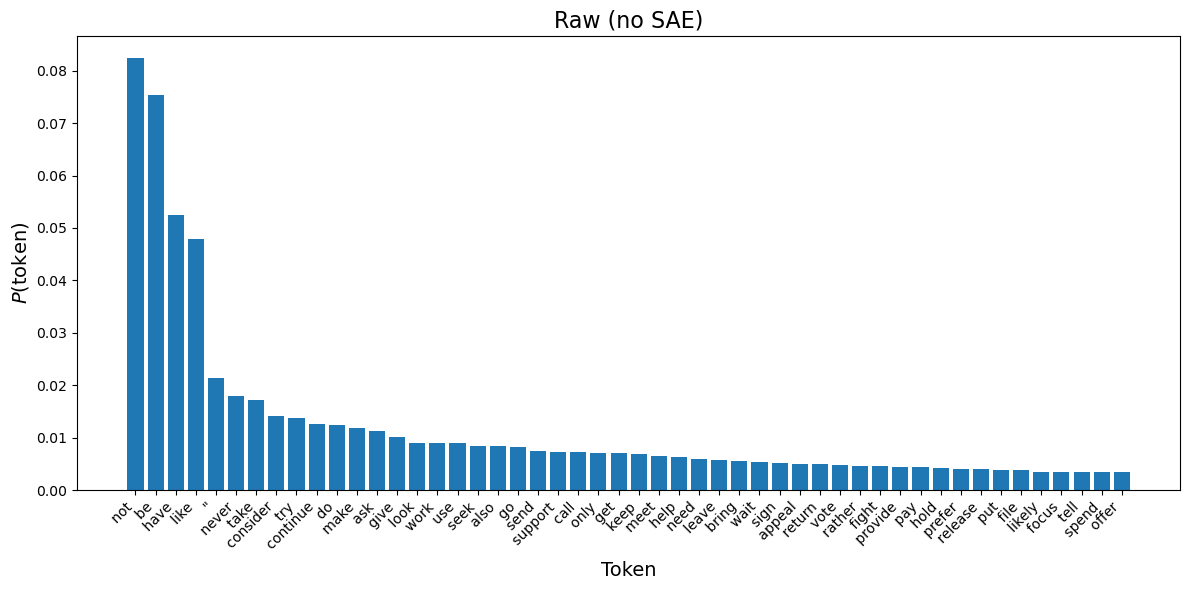

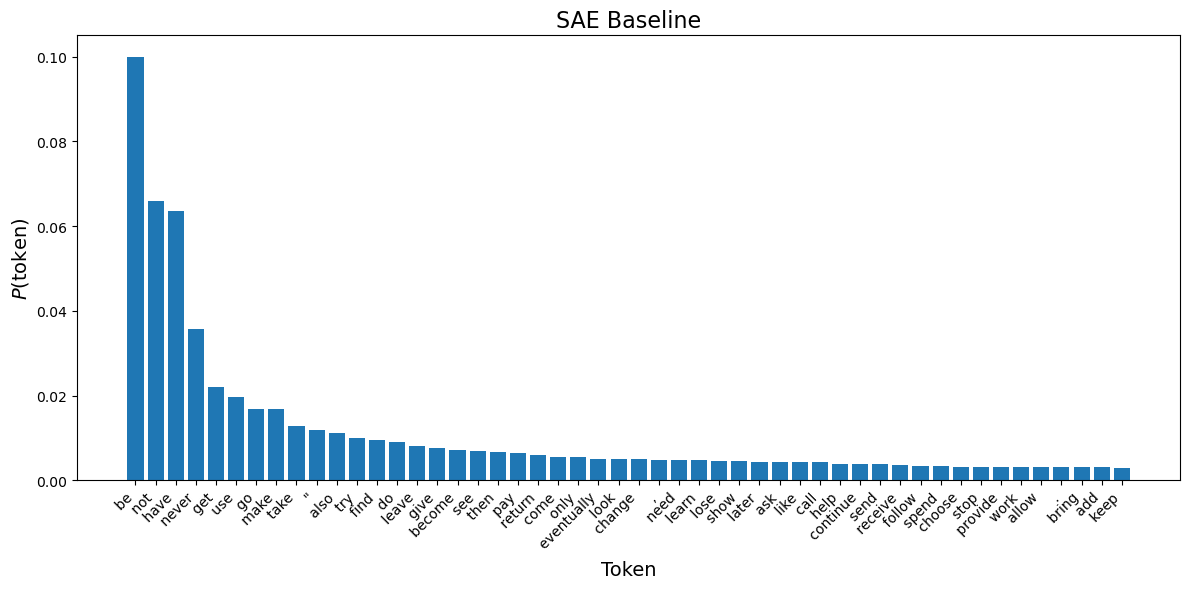

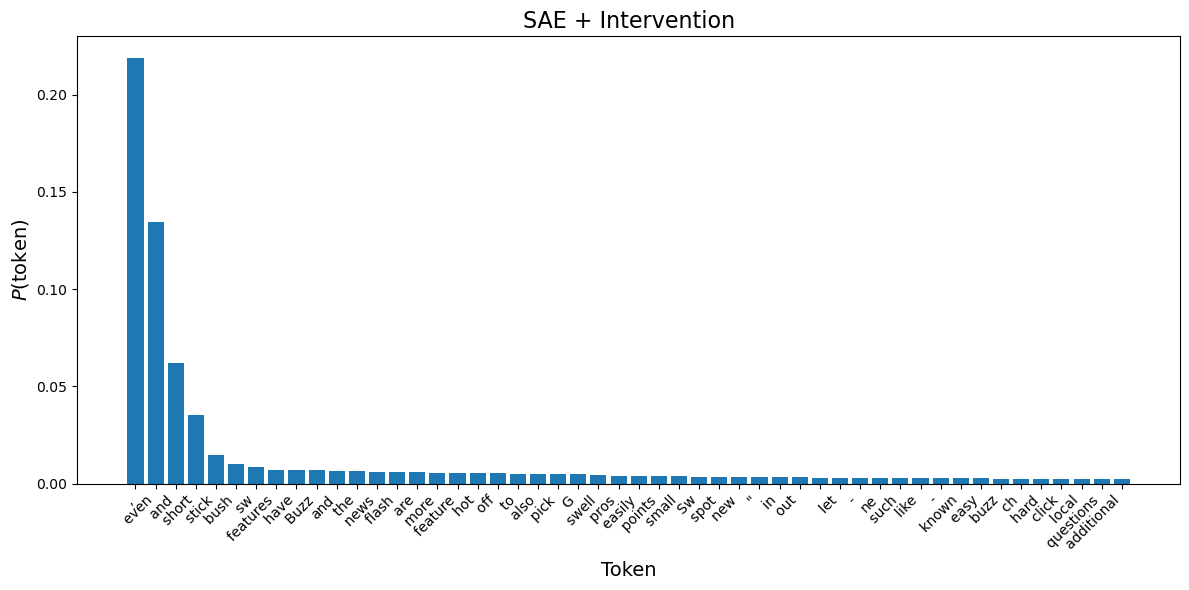

In [5]:
plot_topk_distribution(
    original, 
    use_softmax=True, 
    k=50, 
    position=-1, 
    title="Raw (no SAE)"
)

plot_topk_distribution(
    original_output, 
    use_softmax=True, 
    k=50, 
    position=-1, 
    title="SAE Baseline"
)

plot_topk_distribution(
    modified_output, 
    use_softmax=True, 
    k=50, 
    position=-1, 
    title="SAE + Intervention"
)

In [8]:
results = get_top_k_tokens(
    modified_output,
    k=5,
    tokenizer="gpt2",
    verbose=False
)

In [9]:
df = pd.DataFrame(results)
df

,position,rank,token,probability
0,0,1,.,1.919250e-02
1,0,2,",",1.837287e-02
2,0,3,of,1.616663e-02
3,0,4,-,1.517001e-02
4,0,5,\n,1.512177e-02
5,1,1,that,3.763181e-13
6,1,2,.,3.546041e-13
7,1,3,:,3.247705e-13
8,1,4,the,3.012196e-13
9,1,5,",",2.614347e-13
